# Présentation de fin de stage

## Mise en open source d'une librairie de fairness

1. Contexte
2. Architecture et choix techniques
3. Démo

*Langlade Alexandre encadré par Boissin Thibaut*

# Contexte

- Continuité du travail *Fairness seen as Global Sensitivity Analysis* (Clément Bénesse, Fabrice Gamboa, Jean-Michel Loubes, Thibaut Boissin)

- Rassembler les calculs d'indices en un seul outil

- Modulariser pour l'ajout futur de fonctionnalité

# Architecture et articulation du code

![alt text](architecture.png)

- Modules
    - data_management : gestion, formatage et vérification des données
    - indices : contient les fonctions de calculs
    - visualization : gère l'affichage des résultats
- La liaison entre les modules se fait via la classe FairnessProblem

## La Classe FairnessProblem

![alt text](class_fairnessproblem.png)
### Attributes :
- inputs
- columns
- outputs
- labels
- function
- groups_studied
- categorical_features
- result

La classe passe en paramètre des fonctions.

# Démo



In [1]:
import libfairness
import numpy as np
import pandas as pd
from libfairness.data_management import utils
from libfairness.data_management.factory import create_fairness_problem
from libfairness.indices.standard_metrics import compute_disparate_impact
from libfairness.visualization.standard_metrics_visu import visu_disparate_impact
from libfairness.indices.sobol import compute_sobol
from libfairness.visualization.sobol_visu import visu_sobol
from libfairness.indices.cvm import compute_cvm
from libfairness.visualization.cvm_visu import visu_cvm
from sklearn import tree
from sklearn.datasets import load_iris

In [2]:
headers = ["Older_than_40","Graduated","Gender"]
inputs = np.array([[1., 0.,"Female"], [1., 0.,"Female"], [1., 1.,"Male"], [1., 1.,"Male"], [0., 1.,"Male"], [1., 0.,"Female"], [1., 1.,"Male"], [0., 1.,"Male"], [1., 1.,"Female"], [
                1., 1.,"Male"], [0., 0.,"Female"], [0., 0.,"Female"], [0., 1.,"Female"], [1., 0.,"Male"], [1., 1.,"Male"], [1., 1.,"Male"], [0., 1.,"Male"], [1., 1.,"Male"], [0., 0.,"Female"], [1., 1.,"Female"]])
outputs = np.array([[0],[1],[0],[1],[1],[0],[1],[1],[0],[0],[0],[1],[0],[0],[1],[1],[1],[0],[1],[0]])

datas = pd.DataFrame(inputs,columns=headers)
print(datas)

   Older_than_40 Graduated  Gender
0            1.0       0.0  Female
1            1.0       0.0  Female
2            1.0       1.0    Male
3            1.0       1.0    Male
4            0.0       1.0    Male
5            1.0       0.0  Female
6            1.0       1.0    Male
7            0.0       1.0    Male
8            1.0       1.0  Female
9            1.0       1.0    Male
10           0.0       0.0  Female
11           0.0       0.0  Female
12           0.0       1.0  Female
13           1.0       0.0    Male
14           1.0       1.0    Male
15           1.0       1.0    Male
16           0.0       1.0    Male
17           1.0       1.0    Male
18           0.0       0.0  Female
19           1.0       1.0  Female


In [3]:
my_problem = create_fairness_problem(inputs=inputs, outputs=outputs, categorical_features=["Gender"], columns=headers)
print(my_problem.get_columns())
print(my_problem.get_inputs())

['Older_than_40', 'Graduated', 'Gender']
[['1.0' '0.0' 'Female']
 ['1.0' '0.0' 'Female']
 ['1.0' '1.0' 'Male']
 ['1.0' '1.0' 'Male']
 ['0.0' '1.0' 'Male']
 ['1.0' '0.0' 'Female']
 ['1.0' '1.0' 'Male']
 ['0.0' '1.0' 'Male']
 ['1.0' '1.0' 'Female']
 ['1.0' '1.0' 'Male']
 ['0.0' '0.0' 'Female']
 ['0.0' '0.0' 'Female']
 ['0.0' '1.0' 'Female']
 ['1.0' '0.0' 'Male']
 ['1.0' '1.0' 'Male']
 ['1.0' '1.0' 'Male']
 ['0.0' '1.0' 'Male']
 ['1.0' '1.0' 'Male']
 ['0.0' '0.0' 'Female']
 ['1.0' '1.0' 'Female']]


In [4]:
utils.binarize(my_problem)
my_problem.set_inputs(my_problem.get_inputs().astype(np.float))
print(my_problem.get_columns())
print(my_problem.get_inputs())

['Older_than_40', 'Graduated', 'Gender_Female', 'Gender_Male']
[[1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 1. 0. 1.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [0. 1. 0. 1.]
 [1. 1. 1. 0.]
 [1. 1. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 1. 0.]
 [1. 0. 0. 1.]
 [1. 1. 0. 1.]
 [1. 1. 0. 1.]
 [0. 1. 0. 1.]
 [1. 1. 0. 1.]
 [0. 0. 1. 0.]
 [1. 1. 1. 0.]]


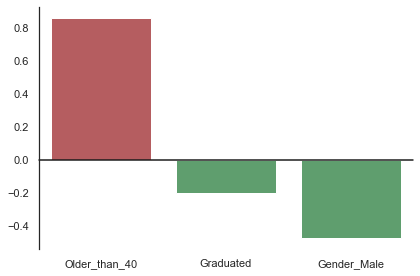

In [5]:
gs = [["Older_than_40"],["Graduated"],["Gender_Male"]]
my_problem.set_groups_studied(gs)
compute_disparate_impact(my_problem)
visu_disparate_impact(my_problem)

## Exemple Sobol

In [6]:
def gaussian_data_generator(sigma12, sigma13, sigma23, N, var1=1., var2=1., var3=1.):
    cov = np.mat([
        [var1, sigma12, sigma13],
        [sigma12, var2, sigma23],
        [sigma13, sigma23, var3]
    ])
    x = np.random.multivariate_normal(
        mean=np.array([0, 0, 0]),
        cov=cov,
        size=N
    )
    return x

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

nsample = 5*10**2
data_sample = 10**4
bootstrap_size = 150

# Data
def func(x): return np.sum(x, axis=1)
data = gaussian_data_generator(
    sigma12=0., sigma13=0., sigma23=0., N=data_sample)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 43.32it/s]


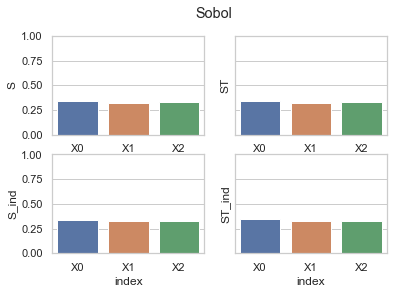

In [7]:
my_problem2 = create_fairness_problem(inputs=data, function=func)
compute_sobol(my_problem2, n=nsample, bs=bootstrap_size)
visu_sobol(my_problem2)

## Exemple Cramér-von-Mises

In [8]:
iris = load_iris()
X, y = iris.data, iris.target

y_train_0 = y[:40]
y_test_0 = y[40:50]
y_train_1 = y[50:90]
y_test_1 = y[90:100]
y_train_2 = y[100:140]
y_test_2 = y[140:150]

y_train = np.concatenate((y_train_0, y_train_1, y_train_2), axis=0)
y_test = np.concatenate((y_test_0, y_test_1, y_test_2), axis=0)

X_train_0 = X[:40, :]
X_test_0 = X[40:50, :]
X_train_1 = X[50:90, :]
X_test_1 = X[90:100, :]
X_train_2 = X[100:140, :]
X_test_2 = X[140:150, :]

X_train = np.concatenate((X_train_0, X_train_1, X_train_2), axis=0)
X_test = np.concatenate((X_test_0, X_test_1, X_test_2), axis=0)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

res = clf.predict(X_test)
headers = ["sep_l","sep_w","pet_l","pet_w"]

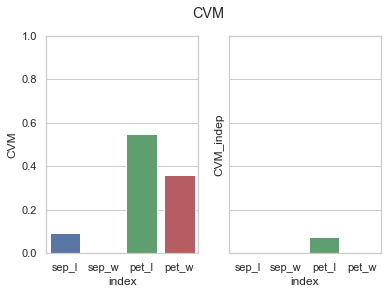

In [9]:
my_problem = create_fairness_problem(inputs=X_test, outputs=res,columns=headers)
compute_cvm(my_problem)
visu_cvm(my_problem)